In [34]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

# F1 data
import fastf1 as f1

In [35]:
f1.Cache.enable_cache("cache")

schedule = pd.DataFrame(f1.get_event_schedule(2025).iloc[1:])
print(schedule.columns)

schedule = schedule[['RoundNumber', 'EventName', 'EventFormat']]

schedule['SprintWeekend'] = schedule['EventFormat'].apply(lambda x: True if x.startswith('sprint') else False)

schedule.drop(columns = ['EventFormat'], inplace=True)

schedule.head()

Index(['RoundNumber', 'Country', 'Location', 'OfficialEventName', 'EventDate',
       'EventName', 'EventFormat', 'Session1', 'Session1Date',
       'Session1DateUtc', 'Session2', 'Session2Date', 'Session2DateUtc',
       'Session3', 'Session3Date', 'Session3DateUtc', 'Session4',
       'Session4Date', 'Session4DateUtc', 'Session5', 'Session5Date',
       'Session5DateUtc', 'F1ApiSupport'],
      dtype='object')


,RoundNumber,EventName,SprintWeekend
1,1,Australian Grand Prix,False
2,2,Chinese Grand Prix,True
3,3,Japanese Grand Prix,False
4,4,Bahrain Grand Prix,False
5,5,Saudi Arabian Grand Prix,False


In [36]:
all_results = pd.read_csv("all_results.csv", index_col=0)

year = 2025

season = f1.get_event_schedule(year)
season = season[~season.is_testing()]

for index, event in season.iterrows():
    if (event['EventDate'] > pd.Timestamp.today()):
        break
    name = event['EventName']

    event = f1.get_event(year, name)
    race = event.get_race()
    race.load(weather=True)

    results = race.results
    

    results = results[['Abbreviation', 'TeamId', 'GridPosition', 'Position', 'Time', 'Status']]

    results.rename(columns={'Abbreviation': 'Driver'}, inplace=True)

    results['Race'] = event['EventName']

    results['TotalTime'] = results['Time']

    leading = 0
    for i in range(1, len(results)):
        if(results['Time'].iloc[i] < results['Time'].iloc[i-1]):
            leading = i-1
        results['TotalTime'].iloc[i] = results['TotalTime'].iloc[leading] + results['Time'].iloc[i]
        

    results["Time"] = results["TotalTime"].astype('int64').replace(-9223372036854775808, np.nan)
    results = results.drop(columns = ['TotalTime'])

    rain = race.weather_data['Rainfall']        
    rain_score = rain.sum() / len(rain)
    results['Rain'] = rain_score
    
    all_results = pd.concat([all_results, results], ignore_index=True)



core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', 

In [37]:
all_results.head()

,Driver,TeamId,GridPosition,Position,Time,Status,Race,Rain
0,LEC,ferrari,1.0,1.0,5.853584e+12,Finished,Bahrain Grand Prix,0.0
1,SAI,ferrari,3.0,2.0,5.859182e+12,Finished,Bahrain Grand Prix,0.0
2,HAM,mercedes,5.0,3.0,5.863259e+12,Finished,Bahrain Grand Prix,0.0
3,RUS,mercedes,9.0,4.0,5.864795e+12,Finished,Bahrain Grand Prix,0.0
4,MAG,haas,7.0,5.0,5.868338e+12,Finished,Bahrain Grand Prix,0.0


In [38]:
all_results.tail()

,Driver,TeamId,GridPosition,Position,Time,Status,Race,Rain
1454,STR,aston_martin,16.0,16.0,4.972008e+12,Lapped,Saudi Arabian Grand Prix,0.0
1455,DOO,alpine,17.0,17.0,4.985745e+12,Lapped,Saudi Arabian Grand Prix,0.0
1456,BOR,sauber,20.0,18.0,4.985787e+12,Lapped,Saudi Arabian Grand Prix,0.0
1457,TSU,red_bull,8.0,19.0,NaN,Retired,Saudi Arabian Grand Prix,0.0
1458,GAS,alpine,9.0,20.0,NaN,Retired,Saudi Arabian Grand Prix,0.0


In [39]:
print(all_results['Status'].unique())
classified = ['Finished', '+1 Lap', '+2 Laps', '+6 Laps', 'Lapped']

['Finished' 'Fuel pressure' 'Power Unit' '+1 Lap' 'Collision damage'
 'Cooling system' 'Water pump' 'Gearbox' 'Accident' 'Withdrew' 'Fuel leak'
 'Spun off' 'Collision' 'Front wing' 'Suspension' 'Water leak' '+2 Laps'
 'Power loss' 'Turbo' 'Mechanical' 'Water pressure' 'Vibrations'
 'Hydraulics' 'Engine' 'Fuel pump' 'Undertray' '+6 Laps' 'Differential'
 'Oil leak' 'Lapped' 'Retired' 'Did not start' 'Disqualified']


In [40]:
all_results['ClassifiedPosition'] = all_results.apply(lambda row: np.nan if row['Status'] not in classified else row['Position'], axis=1)
all_results

,Driver,TeamId,GridPosition,Position,Time,Status,Race,Rain,ClassifiedPosition
0,LEC,ferrari,1.0,1.0,5.853584e+12,Finished,Bahrain Grand Prix,0.0,1.0
1,SAI,ferrari,3.0,2.0,5.859182e+12,Finished,Bahrain Grand Prix,0.0,2.0
2,HAM,mercedes,5.0,3.0,5.863259e+12,Finished,Bahrain Grand Prix,0.0,3.0
3,RUS,mercedes,9.0,4.0,5.864795e+12,Finished,Bahrain Grand Prix,0.0,4.0
4,MAG,haas,7.0,5.0,5.868338e+12,Finished,Bahrain Grand Prix,0.0,5.0
...,...,...,...,...,...,...,...,...,...
1454,STR,aston_martin,16.0,16.0,4.972008e+12,Lapped,Saudi Arabian Grand Prix,0.0,16.0
1455,DOO,alpine,17.0,17.0,4.985745e+12,Lapped,Saudi Arabian Grand Prix,0.0,17.0
1456,BOR,sauber,20.0,18.0,4.985787e+12,Lapped,Saudi Arabian Grand Prix,0.0,18.0
1457,TSU,red_bull,8.0,19.0,NaN,Retired,Saudi Arabian Grand Prix,0.0,NaN


In [41]:
all_results = all_results.drop(columns=['GridPosition', 'Time', 'Status'])
all_results.columns

Index(['Driver', 'TeamId', 'Position', 'Race', 'Rain', 'ClassifiedPosition'], dtype='object')

In [42]:
drivers = all_results['Driver'].unique()
drivers
teams = all_results['TeamId'].unique()
teams

array(['ferrari', 'mercedes', 'haas', 'sauber', 'alpine', 'rb',
       'aston_martin', 'williams', 'mclaren', 'red_bull'], dtype=object)

In [43]:
current_drivers = ['NOR', 'PIA', 'LEC', 'HAM', 'VER', 'TSU', 'OCO', 'BEA', 'LAW', 'HAD', 'ANT', 'RUS', 'GAS', 'DOO', 'ALO', 'STR', 'HUL', 'BOR', 'SAI', 'ALB']

### Current Grand Prix Predictions

In [44]:
race = 'Miami Grand Prix'
round = 6

In [45]:
test = pd.DataFrame([["NOR", "mclaren"], ["PIA", "mclaren"],
                     ["LEC", "ferrari"], ["HAM", "ferrari"],
                     ["VER", "red_bull"], ["TSU", "red_bull"],
                     ["OCO", "haas"], ["BEA", "haas"],
                     ["LAW", "rb"], ["HAD", "rb"],
                     ["ANT", "mercedes"], ["RUS", "mercedes"],
                     ["GAS", "alpine"], ["DOO", "alpine"],
                     ["ALO", "aston_martin"], ["STR", "aston_martin"],
                     ["HUL", "sauber"], ["BOR", "sauber"],
                     ["SAI", "williams"], ["ALB", "williams"]])

test.columns = ['Driver', 'TeamId']
test['Race'] = race
test['Rain'] = 'None'

In [46]:
all_results = pd.concat([all_results, test], ignore_index=True)

test.drop(test.index, inplace=True)

all_results.tail()

,Driver,TeamId,Position,Race,Rain,ClassifiedPosition
1474,STR,aston_martin,NaN,Miami Grand Prix,None,NaN
1475,HUL,sauber,NaN,Miami Grand Prix,None,NaN
1476,BOR,sauber,NaN,Miami Grand Prix,None,NaN
1477,SAI,williams,NaN,Miami Grand Prix,None,NaN
1478,ALB,williams,NaN,Miami Grand Prix,None,NaN


### Calculating lagged performcane metrics

In [47]:
driver_lagged = pd.DataFrame()

ls = []
for driver in drivers:
    dr = all_results[all_results['Driver'] == driver]
    dr['ClassifiedPosition'] = dr['ClassifiedPosition'].ffill()
    dr['DriverLast1'] = dr['ClassifiedPosition'].shift(1)
    dr['DriverLast3'] = dr['DriverLast1'].rolling(window=3, min_periods=1).mean()
    dr['DriverLast5'] = dr['DriverLast1'].rolling(window=5, min_periods=1).mean()
    dr['DriverLast10'] = dr['DriverLast1'].rolling(window=10, min_periods=1).mean()

    if driver in current_drivers:
        ls.append(dr[:-1])
        test = pd.concat([test, pd.DataFrame(dr[-1:])], ignore_index=True)
    else:
        ls.append(dr)

driver_lagged = pd.concat(ls, ignore_index=False)
driver_lagged = driver_lagged.sort_index()

C:\Users\abdul\AppData\Local\Temp\ipykernel_34392\2739688924.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['ClassifiedPosition'] = dr['ClassifiedPosition'].ffill()
C:\Users\abdul\AppData\Local\Temp\ipykernel_34392\2739688924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['DriverLast1'] = dr['ClassifiedPosition'].shift(1)
C:\Users\abdul\AppData\Local\Temp\ipykernel_34392\2739688924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [48]:
driver_lagged = pd.concat([driver_lagged, test], ignore_index=True)
test.drop(test.index, inplace=True)

In [49]:
dataset = driver_lagged.sort_index()

In [50]:
ls = []
test = pd.DataFrame()

orig_dataset = dataset.copy()

for team in teams:
    tm = orig_dataset[orig_dataset["TeamId"] == team].copy()
    if len(tm) < 2:
        continue

    tm["Group"] = (np.arange(len(tm)) // 2).astype(int)
    tm["TeamLast1"] = tm.groupby("Group")["DriverLast1"].transform("mean")

    pair_means = tm.groupby("Group")["TeamLast1"].first()
    roll3 = pair_means.rolling(3, min_periods=1).mean()
    roll5 = pair_means.rolling(5, min_periods=1).mean()
    roll10 = pair_means.rolling(10, min_periods=1).mean()

    tm["TeamLast3"] = tm["Group"].map(roll3)
    tm["TeamLast5"] = tm["Group"].map(roll5)
    tm["TeamLast10"] = tm["Group"].map(roll10)

    ls.append(tm.iloc[:-2])
    test = pd.concat([test, tm.iloc[-2:]], ignore_index=True)

dataset = pd.concat(ls, ignore_index=False) if ls else orig_dataset
dataset

,Driver,TeamId,Position,Race,Rain,ClassifiedPosition,DriverLast1,DriverLast3,DriverLast5,DriverLast10,Group,TeamLast1,TeamLast3,TeamLast5,TeamLast10
0,LEC,ferrari,1.0,Bahrain Grand Prix,0.0,1.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
1,SAI,ferrari,2.0,Bahrain Grand Prix,0.0,2.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
21,LEC,ferrari,2.0,Saudi Arabian Grand Prix,0.0,2.0,1.0,1.000000,1.0,1.0,1,1.5,1.500000,1.5,1.50
22,SAI,ferrari,3.0,Saudi Arabian Grand Prix,0.0,3.0,2.0,2.000000,2.0,2.0,1,1.5,1.500000,1.5,1.50
40,LEC,ferrari,1.0,Australian Grand Prix,0.0,1.0,2.0,1.500000,1.5,1.5,2,2.5,2.000000,2.0,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,TSU,red_bull,12.0,Japanese Grand Prix,0.0,12.0,16.0,13.333333,12.4,12.6,70,10.0,10.333333,8.8,8.35
1424,VER,red_bull,6.0,Bahrain Grand Prix,0.0,6.0,1.0,2.333333,2.8,3.1,71,6.5,8.666667,8.6,7.90
1427,TSU,red_bull,9.0,Bahrain Grand Prix,0.0,9.0,12.0,13.333333,13.0,12.1,71,6.5,8.666667,8.6,7.90
1440,VER,red_bull,2.0,Saudi Arabian Grand Prix,0.0,2.0,6.0,3.666667,3.8,3.5,72,7.5,8.000000,9.0,8.05


In [51]:
"""ls = []
for team in teams:
    tm = dataset[dataset['TeamId'] == team]

    tm['Group'] = np.floor(np.arange(len(tm)) / 2)

    race_avg = tm.groupby('Group')['DriverLast1'].transform('mean')
    group_means = race_avg.groupby(tm['Group']).first()

    rolling_3 = group_means.rolling(window=3, min_periods=1).mean()
    rolling_5 = group_means.rolling(window=5, min_periods=1).mean()
    rolling_10 = group_means.rolling(window=10, min_periods=1).mean()

    tm['TeamLast1'] = race_avg
    tm['TeamLast3']  = tm['Group'].map(rolling_3)
    tm['TeamLast5']  = tm['Group'].map(rolling_5)
    tm['TeamLast10'] = tm['Group'].map(rolling_10)
    print(tm)
    
    ls.append(tm[:-2])

    test = pd.concat([test, pd.DataFrame(tm[-2:])], ignore_index=True)
    
dataset = pd.concat(ls, ignore_index=False)
"""


"ls = []\nfor team in teams:\n    tm = dataset[dataset['TeamId'] == team]\n\n    tm['Group'] = np.floor(np.arange(len(tm)) / 2)\n\n    race_avg = tm.groupby('Group')['DriverLast1'].transform('mean')\n    group_means = race_avg.groupby(tm['Group']).first()\n\n    rolling_3 = group_means.rolling(window=3, min_periods=1).mean()\n    rolling_5 = group_means.rolling(window=5, min_periods=1).mean()\n    rolling_10 = group_means.rolling(window=10, min_periods=1).mean()\n\n    tm['TeamLast1'] = race_avg\n    tm['TeamLast3']  = tm['Group'].map(rolling_3)\n    tm['TeamLast5']  = tm['Group'].map(rolling_5)\n    tm['TeamLast10'] = tm['Group'].map(rolling_10)\n    print(tm)\n    \n    ls.append(tm[:-2])\n\n    test = pd.concat([test, pd.DataFrame(tm[-2:])], ignore_index=True)\n    \ndataset = pd.concat(ls, ignore_index=False)\n"

In [52]:
bins = [-0.001, 0, 0.1, 0.5, dataset['Rain'].max() + 0.001]
labels = ['None', 'Light', 'Moderate', 'Heavy']

dataset['Rain'] = pd.cut(dataset['Rain'], bins=bins, labels=labels)

In [53]:
dataset.columns

Index(['Driver', 'TeamId', 'Position', 'Race', 'Rain', 'ClassifiedPosition',
       'DriverLast1', 'DriverLast3', 'DriverLast5', 'DriverLast10', 'Group',
       'TeamLast1', 'TeamLast3', 'TeamLast5', 'TeamLast10'],
      dtype='object')

In [54]:
dataset = dataset.drop(columns=['ClassifiedPosition', 'Group'])
dataset.sort_index()
test = test[dataset.columns]
dataset = dataset.sort_index()

In [55]:
# Define features
categorical_features = ['Driver', 'TeamId', 'Race', 'Rain']
numerical_features = [col for col in dataset.columns 
                      if col not in categorical_features + ['Position', 'ClassifiedPosition']]

# Drop rows with missing target
dataset = dataset.dropna()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='error'), categorical_features)
])

# Pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


## Fitting the model with the dataset

In [56]:
# Features and target
X = dataset[categorical_features + numerical_features]
print(X['Driver'].unique())
y = dataset['Position']

model_pipeline.fit(X, y)

# Define K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = cross_val_score(model_pipeline, X, y, cv=kfold, scoring="neg_mean_absolute_error")

print(mae_scores.mean())

['LEC' 'SAI' 'RUS' 'OCO' 'NOR' 'MAG' 'HAM' 'ZHO' 'HUL' 'STR' 'ALB' 'BOT'
 'ALO' 'RIC' 'LAT' 'TSU' 'PER' 'GAS' 'MSC' 'VER' 'VET' 'DEV' 'SAR' 'PIA'
 'LAW' 'COL' 'BEA' 'DOO' 'ANT' 'HAD' 'BOR']
-3.4501914597123373


In [57]:
test = test.drop(columns=['Position'])

In [58]:
X = test[categorical_features + numerical_features]
pred = pd.DataFrame(model_pipeline.predict(X))
print(pred.var())

0    18.179437
dtype: float64


In [59]:
pred.columns = ["Position"]

prediction = pd.concat([test, pred], axis=1)

prediction = prediction.sort_values(by='Position', ascending=True)

prediction


,Driver,TeamId,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
17,PIA,mclaren,Miami Grand Prix,None,1.0,1.666667,3.00,5.100000,2.5,2.333333,2.7,4.40,3.60
16,NOR,mclaren,Miami Grand Prix,None,4.0,3.000000,2.40,3.700000,2.5,2.333333,2.7,4.40,3.64
2,RUS,mercedes,Miami Grand Prix,None,5.0,4.000000,3.60,3.700000,5.5,5.833333,5.1,5.15,3.98
0,LEC,ferrari,Miami Grand Prix,None,3.0,3.666667,5.40,4.400000,5.0,5.000000,6.6,4.90,4.57
19,VER,red_bull,Miami Grand Prix,None,2.0,3.000000,3.00,3.400000,5.5,6.500000,7.8,8.10,5.48
3,ANT,mercedes,Miami Grand Prix,None,6.0,7.666667,6.60,6.600000,5.5,5.833333,5.1,5.15,6.38
1,HAM,ferrari,Miami Grand Prix,None,7.0,6.333333,7.80,7.100000,5.0,5.000000,6.6,4.90,8.70
14,SAI,williams,Miami Grand Prix,None,8.0,12.000000,9.60,6.100000,10.0,11.166667,8.3,11.25,10.23
15,ALB,williams,Miami Grand Prix,None,9.0,10.000000,8.40,11.600000,9.0,11.000000,9.4,10.75,11.42
12,ALO,aston_martin,Miami Grand Prix,None,11.0,12.333333,11.00,10.900000,13.5,15.000000,12.3,12.15,11.74


In [60]:
australia = dataset[(1-round)*20 : (2-round)*20].reset_index(drop=True)
china = dataset[(2-round)*20 : (3-round)*20].reset_index(drop=True)
japan = dataset[(3-round)*20 : (4-round)*20].reset_index(drop=True)
bahrain = dataset[(4-round)*20 : (5-round)*20].reset_index(drop=True)
saudi = dataset[(5-round)*20 :]

previous = [australia, china, japan, bahrain]

In [61]:
predictions = []

for race in previous:
    test = race
    
    test.rename(columns={'Position': 'TruePosition'}, inplace=True)

    X = test[categorical_features + numerical_features]

    pred = pd.DataFrame(model_pipeline.predict(X))
    print(pred.var())

    pred.columns = ["Position"]

    pred = pd.concat([test, pred], axis=1)

    pred = pred.sort_values(by='Position', ascending=True) 
    predictions.append(pred)

    mae = mean_absolute_error(pred['TruePosition'], pred['Position'])
    print(mae)


0    20.355143
dtype: float64
1.535
0    22.16078
dtype: float64
1.8159999999999996
0    25.298037
dtype: float64
1.0565
0    23.236275
dtype: float64
1.2360000000000002


In [62]:
predictions[0]

,Driver,TeamId,TruePosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
5,NOR,mclaren,1.0,Australian Grand Prix,Moderate,1.0,5.666667,5.000000,3.800000,5.5,6.166667,6.1,4.45,2.97
6,VER,red_bull,2.0,Australian Grand Prix,Moderate,6.0,4.000000,3.800000,3.700000,11.5,8.166667,8.4,7.50,3.61
7,RUS,mercedes,3.0,Australian Grand Prix,Moderate,5.0,3.333333,3.800000,4.600000,5.0,4.833333,5.2,5.65,3.90
11,LEC,ferrari,8.0,Australian Grand Prix,Moderate,3.0,3.000000,3.400000,2.900000,3.5,3.666667,3.2,4.00,6.81
12,PIA,mclaren,9.0,Australian Grand Prix,Moderate,10.0,6.666667,7.200000,5.100000,5.5,6.166667,6.1,4.45,7.85
8,ALB,williams,5.0,Australian Grand Prix,Moderate,11.0,14.000000,14.800000,12.700000,12.5,14.333333,14.2,12.30,8.98
10,HUL,sauber,7.0,Australian Grand Prix,Moderate,8.0,8.000000,8.400000,9.800000,8.0,11.000000,12.3,14.65,9.30
9,STR,aston_martin,6.0,Australian Grand Prix,Moderate,14.0,14.666667,13.200000,14.600000,11.5,11.833333,12.0,12.40,9.39
13,HAM,ferrari,10.0,Australian Grand Prix,Moderate,4.0,6.000000,6.400000,6.600000,3.5,3.666667,3.2,4.00,9.64
15,TSU,rb,12.0,Australian Grand Prix,Moderate,12.0,11.333333,11.000000,13.200000,12.0,12.666667,12.2,13.15,11.31


In [63]:
predictions[1]

,Driver,TeamId,TruePosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
3,NOR,mclaren,2.0,Chinese Grand Prix,None,1.0,4.000000,4.80,3.80,5.0,5.666667,6.1,4.70,2.57
4,RUS,mercedes,3.0,Chinese Grand Prix,None,3.0,4.000000,3.40,4.20,3.5,5.500000,5.0,5.25,4.00
2,PIA,mclaren,1.0,Chinese Grand Prix,None,9.0,7.333333,7.40,5.60,5.0,5.666667,6.1,4.70,4.05
5,VER,red_bull,4.0,Chinese Grand Prix,None,2.0,3.000000,3.00,3.70,9.5,8.833333,8.0,8.05,4.24
7,ANT,mercedes,6.0,Chinese Grand Prix,None,4.0,4.000000,4.00,4.00,3.5,5.500000,5.0,5.25,5.34
6,OCO,haas,5.0,Chinese Grand Prix,None,13.0,15.666667,12.40,13.70,13.5,12.166667,10.9,11.00,7.83
9,BEA,haas,8.0,Chinese Grand Prix,None,14.0,12.000000,10.75,10.75,13.5,12.166667,10.9,11.00,8.87
11,SAI,williams,10.0,Chinese Grand Prix,None,2.0,3.333333,2.80,4.60,4.5,6.833333,10.2,10.65,9.74
8,ALB,williams,7.0,Chinese Grand Prix,None,5.0,10.333333,12.60,11.80,3.5,10.166667,12.1,11.10,10.18
10,STR,aston_martin,9.0,Chinese Grand Prix,None,6.0,11.666667,12.20,13.90,7.5,10.000000,11.1,12.00,10.58


In [64]:
predictions[2]

,Driver,TeamId,TruePosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
0,VER,red_bull,1.0,Japanese Grand Prix,None,4.0,4.000000,3.600000,3.500000,10.0,10.333333,8.8,8.35,2.53
1,NOR,mclaren,2.0,Japanese Grand Prix,None,2.0,1.333333,4.000000,3.700000,1.5,4.000000,5.0,4.60,3.19
2,PIA,mclaren,3.0,Japanese Grand Prix,None,1.0,6.666667,6.000000,5.500000,1.5,4.000000,5.0,4.60,4.02
3,LEC,ferrari,4.0,Japanese Grand Prix,None,8.0,6.333333,5.000000,4.100000,9.0,7.166667,5.8,5.15,4.53
4,RUS,mercedes,5.0,Japanese Grand Prix,None,3.0,3.666667,3.200000,3.800000,4.5,4.333333,4.5,5.10,4.67
6,HAM,ferrari,7.0,Japanese Grand Prix,None,10.0,8.000000,7.600000,7.300000,9.0,7.166667,5.8,5.15,6.44
5,ANT,mercedes,6.0,Japanese Grand Prix,None,6.0,5.000000,5.000000,5.000000,4.5,4.333333,4.5,5.10,6.80
8,ALB,williams,9.0,Japanese Grand Prix,None,7.0,7.666667,10.800000,11.600000,4.5,6.833333,10.2,10.65,10.51
7,HAD,rb,8.0,Japanese Grand Prix,None,11.0,11.000000,11.000000,11.000000,11.5,11.833333,12.3,12.55,10.61
9,BEA,haas,10.0,Japanese Grand Prix,None,8.0,11.333333,10.200000,10.200000,6.5,11.500000,10.6,10.45,10.63


In [65]:
predictions[3]

,Driver,TeamId,TruePosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
0,PIA,mclaren,1.0,Bahrain Grand Prix,None,3.0,4.333333,5.200000,5.700000,2.5,3.000000,4.2,4.60,2.12
1,RUS,mercedes,2.0,Bahrain Grand Prix,None,5.0,3.666667,4.000000,4.000000,5.5,4.500000,5.3,5.05,3.53
2,NOR,mclaren,3.0,Bahrain Grand Prix,None,2.0,1.666667,3.200000,3.500000,2.5,3.000000,4.2,4.60,3.82
3,LEC,ferrari,4.0,Bahrain Grand Prix,None,4.0,6.666667,5.000000,4.300000,5.5,7.833333,6.2,4.70,4.97
5,VER,red_bull,6.0,Bahrain Grand Prix,None,1.0,2.333333,2.800000,3.100000,6.5,8.666667,8.6,7.90,5.45
4,HAM,ferrari,5.0,Bahrain Grand Prix,None,7.0,9.000000,8.600000,7.100000,5.5,7.833333,6.2,4.70,6.01
6,GAS,alpine,7.0,Bahrain Grand Prix,None,13.0,11.666667,9.400000,9.200000,14.0,13.000000,11.0,10.90,8.86
10,ANT,mercedes,11.0,Bahrain Grand Prix,None,6.0,5.333333,5.333333,5.333333,5.5,4.500000,5.3,5.05,9.56
7,OCO,haas,8.0,Bahrain Grand Prix,None,18.0,12.000000,14.000000,13.100000,14.0,11.333333,11.4,10.80,10.16
8,TSU,red_bull,9.0,Bahrain Grand Prix,None,12.0,13.333333,13.000000,12.100000,6.5,8.666667,8.6,7.90,10.36


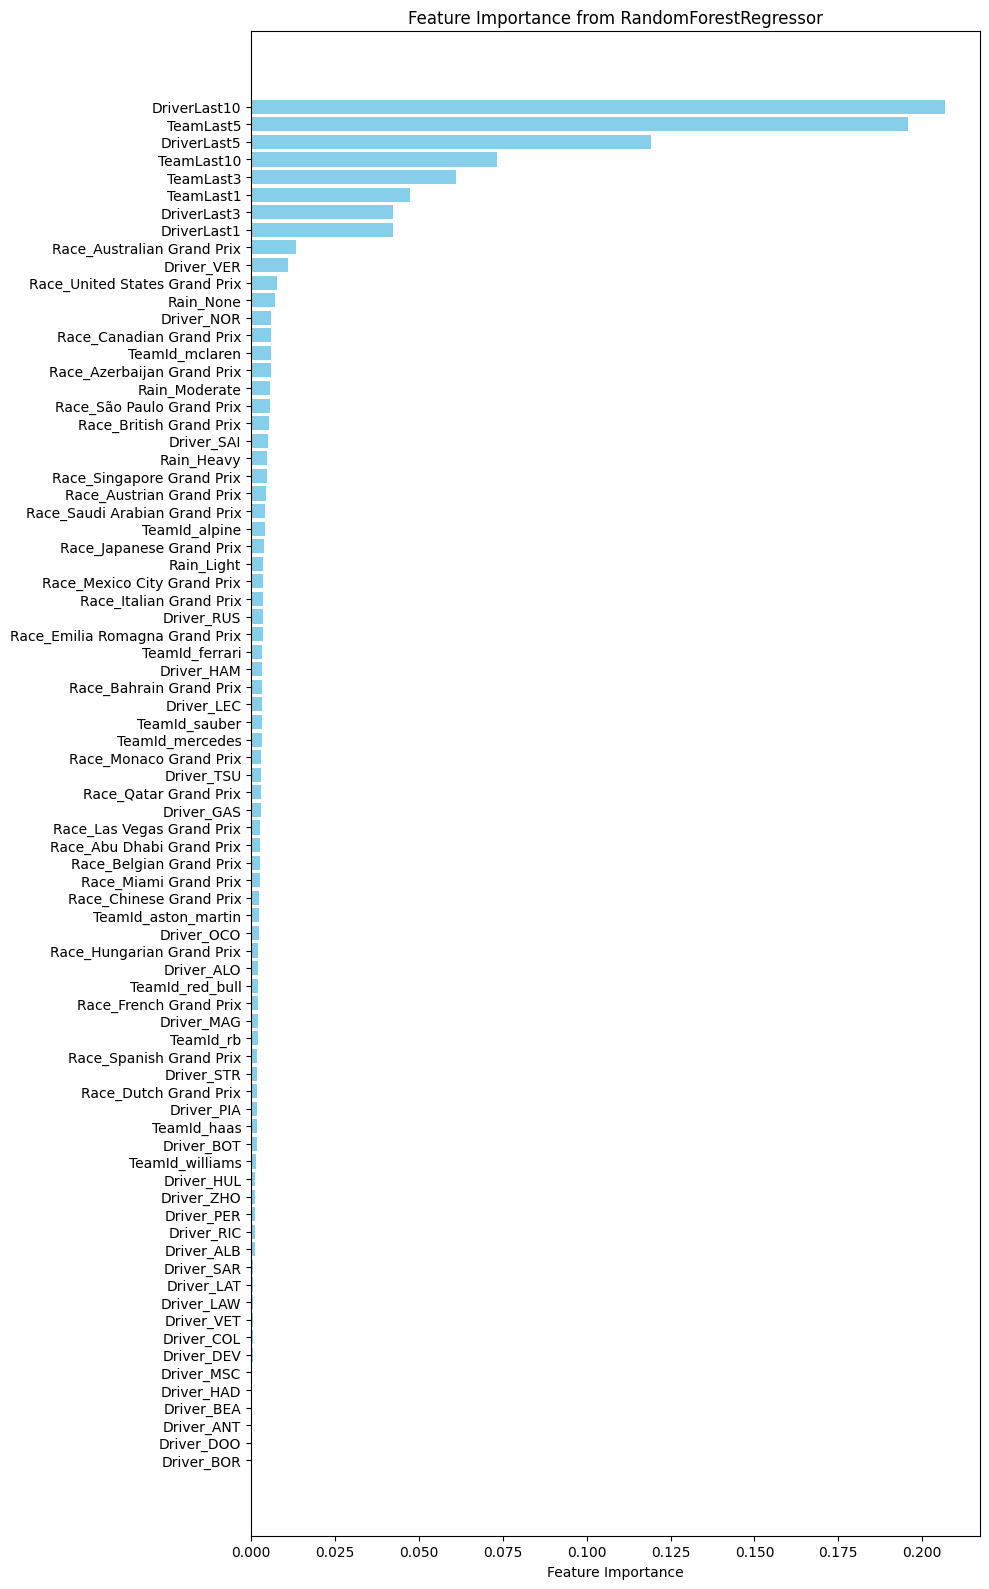

In [66]:
# Get the transformer for categorical features from your preprocessor
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']

# Get one-hot encoded feature names (e.g., "Driver_VER", etc.)
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# The final feature names are (typically) the numerical features first,
# followed by the transformed categorical features.
final_feature_names = list(numerical_features) + list(cat_feature_names)

# --- Step 2: Retrieve Feature Importances from the RandomForestRegressor ---
# Access the regressor within the pipeline
rf_model = model_pipeline.named_steps['regressor']

# Get the feature importances array
importances = rf_model.feature_importances_

# Create a DataFrame for convenience and sort by importance
importance_df = pd.DataFrame({
    'feature': final_feature_names,
    'importance': importances
})
importance_df.sort_values(by='importance', ascending=True, inplace=True)

# --- Step 3: Plot the Feature Importance Chart ---
plt.figure(figsize=(10, 16))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance from RandomForestRegressor")
plt.tight_layout()
plt.show()